**Ben Seifert. November 3, 2017. General Assembly**

# Ames Housing Price Prediction

In this notebook I aim to create a regression model so as to predict the price of a house.  Enjoy.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from scipy.stats import skew

## Read in the Data

In [3]:
df = pd.read_csv('amesTrain.csv')

In [5]:
# 2,051 rows and 82 columns in this dataset

df.shape

(2051, 82)

In [6]:
df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [11]:
# Check to see if any of the ID's are duplicates due to human entering error

idsUnique = len(set(df.Id))
idsTotal = df.shape[0]
idsDuplicate = idsTotal - idsUnique
print("There are " + str(idsDuplicate) + " duplicate IDs for" + str(idsTotal) + "total entries.")

There are 0 duplicate IDs for2051total entries.


# EDA

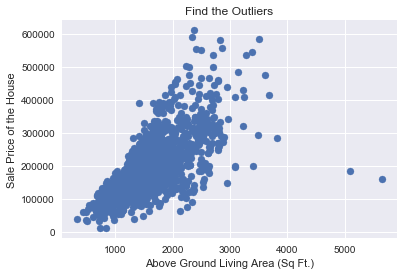

In [12]:
plt.scatter(df['Gr Liv Area'], df['SalePrice'])
plt.title('Find the Outliers')
plt.xlabel('Above Ground Living Area (Sq Ft.)')
plt.ylabel('Sale Price of the House')
plt.draw()

Clearly there are outliers. We wouldn't expect a house with above ground living area greater than 4,000 sq.feet for as cheap as that is. Thereforore let's take these houses out.

In [14]:
df = df[df['Gr Liv Area'] < 4000]

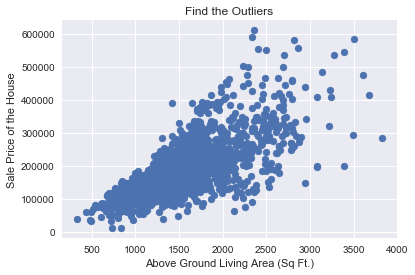

In [15]:
plt.scatter(df['Gr Liv Area'], df['SalePrice'])
plt.title('Find the Outliers')
plt.xlabel('Above Ground Living Area (Sq Ft.)')
plt.ylabel('Sale Price of the House')
plt.draw()

No more outliers in that sense. On to the next one. Let's compare Sale Price to the lot area.

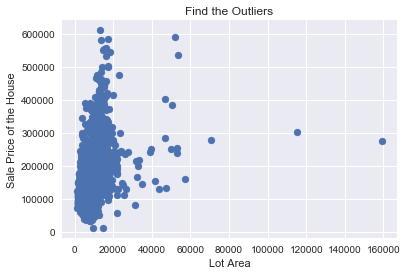

In [17]:
plt.scatter(df['Lot Area'], df['SalePrice'])
plt.title('Find the Outliers')
plt.xlabel('Lot Area')
plt.ylabel('Sale Price of the House')
plt.draw()

I can imagine that there might be a house with a great plot of land at a low price.  Therefore I will not remove these outliers.

Next I will look at Sale Price compared to the year the garage was built.

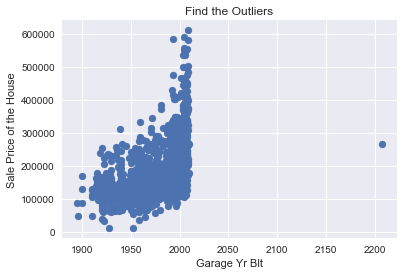

In [18]:
plt.scatter(df['Garage Yr Blt'], df['SalePrice'])
plt.title('Find the Outliers')
plt.xlabel('Garage Yr Blt')
plt.ylabel('Sale Price of the House')
plt.draw()

It would be impossible to have a house built after the year 2017 (Today's date is November 3, 2017). We should remove that outlier.

In [20]:
df = df[df['Garage Yr Blt'] < 2018]

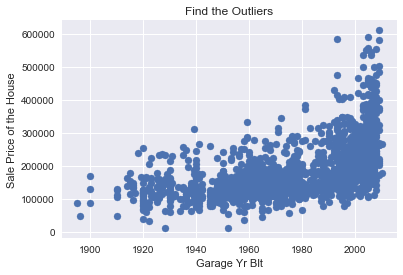

In [21]:
plt.scatter(df['Garage Yr Blt'], df['SalePrice'])
plt.title('Find the Outliers')
plt.xlabel('Garage Yr Blt')
plt.ylabel('Sale Price of the House')
plt.draw()

That looks much better. Next lets get rid of any null values by imputing values in. I chose the manual way which was time consuming but I learned the hard way and now understand the underlying process behind why EDA takes so long. My method was to use the code below on the columns that were null values.

**I first found the columns with null values**

In [27]:
df.columns[df.isnull().any()]

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')

**Depending on the distribution I either Imputed or Dropped the null values**

In [31]:
# GarageYrBlt measures the year the garage built. Nan most likely means No 
df.loc[:,'Garage Yr Blt'] = df.loc[:, 'Garage Yr Blt'].fillna(df['Garage Yr Blt'].median())

# Alley measures if the house has acces to an Alley. Nan most likely means No
df.loc[:, "Alley"] = df.loc[:, "Alley"].fillna("None")

# BsmtQual measures the height of the basement. Nan most likely means No
df.loc[:, "Bsmt Qual"] = df.loc[:, "Bsmt Qual"].fillna("No")

# BsmtCond measures the condition of the basement. Nan most likely means No
df.loc[:, "Bsmt Cond"] = df.loc[:, "Bsmt Cond"].fillna("No")

# BsmtExposure measures if the basement is exposed or underground. Nan most likely means No
df.loc[:, "Bsmt Exposure"] = df.loc[:, "Bsmt Exposure"].fillna("No")

# BsmtFinType1 measures the rating of the finished basement area. Nan most likely means No. BsmtFinType2 implies two basements
df.loc[:, "BsmtFin Type 1"] = df.loc[:, "BsmtFin Type 1"].fillna("No")
df.loc[:, "BsmtFin Type 2"] = df.loc[:, "BsmtFin Type 2"].fillna("No")
df.loc[:, 'BsmtFin SF 1'] = df.loc[:, 'BsmtFin SF 1'].fillna(0)
df.loc[:, 'BsmtFin SF 2'] = df.loc[:, 'BsmtFin SF 2'].fillna(0)

# BsmtFull/HalfBath measures the number of basement bathrooms. Nan most likely means No
df.loc[:, "Bsmt Full Bath"] = df.loc[:, "Bsmt Full Bath"].fillna(0)
df.loc[:, "Bsmt Half Bath"] = df.loc[:, "Bsmt Half Bath"].fillna(0)

# BsmtUnfSF measures the basement SquareFeet. Nan most likely means No
df.loc[:, "Bsmt Unf SF"] = df.loc[:, "Bsmt Unf SF"].fillna(0)
df.loc[:, 'Total Bsmt SF'] = df.loc[:, 'Total Bsmt SF'].fillna(0)

# Fence measures fence quality. Nan most likely means No
df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No")

# FireplaceQU measures fireplace quality. Nan most likely means No
df.loc[:, "Fireplace Qu"] = df.loc[:, "Fireplace Qu"].fillna("No")

# GarageType etc : data description says NA for garage features is "no garage"
df.loc[:, "Garage Type"] = df.loc[:, "Garage Type"].fillna("No")
df.loc[:, "Garage Finish"] = df.loc[:, "Garage Finish"].fillna("No")
df.loc[:, "Garage Qual"] = df.loc[:, "Garage Qual"].fillna("No")
df.loc[:, "Garage Cond"] = df.loc[:, "Garage Cond"].fillna("No")
df.loc[:, "Garage Area"] = df.loc[:, "Garage Area"].fillna(0)
df.loc[:, "Garage Cars"] = df.loc[:, "Garage Cars"].fillna(0)

# LotFrontage : NA most likely means no lot frontage
df.loc[:, "Lot Frontage"] = df.loc[:, "Lot Frontage"].fillna(0)

# MasVnrType : NA most likely means no veneer
df.loc[:, "Mas Vnr Type"] = df.loc[:, "Mas Vnr Type"].fillna("None")
df.loc[:, "Mas Vnr Area"] = df.loc[:, "Mas Vnr Area"].fillna(0)

# MiscFeature : data description says NA means "no misc feature"
df.loc[:, "Misc Feature"] = df.loc[:, "Misc Feature"].fillna("No")

# PoolQC : data description says NA means "no pool"
df.loc[:, "Pool QC"] = df.loc[:, "Pool QC"].fillna("No")

In [33]:
# No more null values, now to finish Binarizing.

df.columns[df.isnull().any()]

Index([], dtype='object')

With no null values remaining, we can begin to Binarize/Impute strings to numbers.  This technique will allow us to run our future model as a regression.

In [34]:
df = df.replace({"Alley" : {"Grvl" : 0, "Pave" : 1},
                       "Bsmt Cond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Bsmt Exposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFin Type 1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                       "BsmtFin Type 2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                       "Bsmt Qual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "Exter Cond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "Exter Qual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "Fireplace Qu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "Garage Cond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Garage Qual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Heating QC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Kitchen Qual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Land Slope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "Lot Shape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "Paved Drive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "Pool QC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [38]:
df['Bsmt Cond'].unique()

array([3, 4, 0, 2, 5, 1])

Let's drop any columns that are not needed.

In [39]:
df.drop('Id', axis=1, inplace=True)
df.drop('PID', axis=1, inplace=True)
df.drop('Alley', axis=1, inplace=True)

# Build a Model: Regression

#### Below we will begin to create a model that predicts the sale price of a house in this dataset.

Correlation Matrix can help visualize important columns.  With this big of a dataset (70+ rows) it will be tough to really dig into this.

In [46]:
df.corr()

,MS SubClass,Lot Frontage,Lot Area,Street,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Misc Val,Mo Sold,Yr Sold,SalePrice
MS SubClass,1.000000,-0.229295,-0.251037,0.036776,0.055062,0.024017,0.032110,0.069471,-0.106932,0.083429,...,-0.012953,-0.061330,-0.028977,-0.033722,-0.003847,-0.007653,-0.031146,0.014547,-0.030477,-0.069609
Lot Frontage,-0.229295,1.000000,0.099870,-0.034548,0.203562,0.019813,0.006619,0.107040,-0.021499,0.015293,...,0.083265,0.013474,0.009807,0.039330,0.048261,0.039603,-0.007482,-0.002405,0.002216,0.191625
Lot Area,-0.251037,0.099870,1.000000,-0.019392,-0.286005,-0.030249,-0.322642,0.073781,-0.016506,0.009902,...,0.117586,0.022848,0.020326,0.065077,0.069510,0.066695,0.044874,0.006498,-0.032959,0.291471
Street,0.036776,-0.034548,-0.019392,1.000000,-0.019451,0.198798,0.030569,0.058355,-0.001348,0.074879,...,0.016864,-0.083729,0.005271,0.015080,0.003128,0.003027,0.003803,0.022689,-0.039595,0.066754
Lot Shape,0.055062,0.203562,-0.286005,-0.019451,1.000000,0.013326,0.103804,-0.234433,0.079490,-0.266884,...,-0.077443,0.081761,-0.029121,-0.065056,-0.010465,-0.016808,-0.047033,-0.014789,0.035356,-0.284077
Utilities,0.024017,0.019813,-0.030249,0.198798,0.013326,1.000000,-0.006651,0.033520,0.006855,0.032769,...,-0.018057,0.011115,0.003160,-0.071558,0.001875,0.001815,0.003029,0.050853,-0.028385,0.028996
Land Slope,0.032110,0.006619,-0.322642,0.030569,0.103804,-0.006651,1.000000,0.022631,-0.026090,0.056370,...,0.018572,-0.039888,-0.015275,-0.049504,0.013389,0.012955,0.002128,0.004933,-0.014168,-0.064765
Overall Qual,0.069471,0.107040,0.073781,0.058355,-0.234433,0.033520,0.022631,1.000000,-0.133582,0.601125,...,0.306078,-0.144964,0.030977,0.034643,-0.014943,-0.003748,-0.022182,0.023431,-0.009478,0.799132
Overall Cond,-0.106932,-0.021499,-0.016506,-0.001348,0.079490,0.006855,-0.026090,-0.133582,1.000000,-0.413621,...,-0.074132,0.111785,0.023410,0.044822,-0.003519,-0.005496,0.034376,0.006919,0.051443,-0.128240
Year Built,0.083429,0.015293,0.009902,0.074879,-0.266884,0.032769,0.056370,0.601125,-0.413621,1.000000,...,0.227922,-0.365670,0.017146,-0.054187,-0.007603,-0.003736,-0.022898,-0.001050,0.001549,0.560809


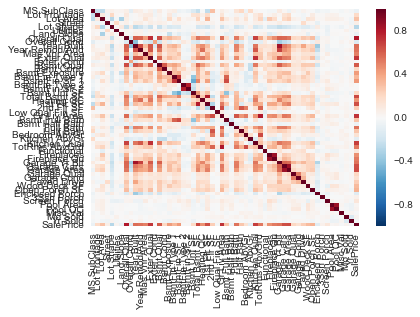

In [47]:
corr  = df.corr()
sns.heatmap(corr)
plt.show()

Columns highly correlated with Sale price (Above .6):

'Overall Qual' 0.79

'Total Bsmt SF' 0.66

'1st Flr SF' 0.64

'Gr Liv Area' 0.725

'Garage Cars' 0.64

'Garage Area' 0.65

Other columns I feel will come into play with price:

'Year Built' 0.56

'Year Remod/Add' 0.55

'Mas Vnr Area' 0.52

'Bsmt Fin SF 1' 0.44

'Full Bath' 0.53

'Fireplaces' 0.47

'Garage Yr Blt' 0.53

In [48]:
# create target and predictor  variables

X = df[['Overall Qual', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Garage Cars', 'Garage Area', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Yr Blt']]
y = df['SalePrice']

In [51]:
# TTS the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [52]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1353, 13) (1353,)
(581, 13) (581,)


You should always perform tests like the above just so you know that you have a working set of data to create a model with.  If the rows were different or the columns were different then I would know that there is something to fix.  That it was it is important to constantly be checking what you have done.

In [53]:
reg = KNeighborsRegressor()
reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [55]:
print("Score of Training Set:", reg.score(X_train, y_train))
print("Score of Test Set:", reg.score(X_test, y_test))

Score of Training Set: 0.845996092579
Score of Test Set: 0.775355700818


In [62]:
print("Average predicted price of house:", reg.predict(X_test).mean())

Average predicted price of house: 192154.15043


This model is ok. Not terrible but just ok.  We might have a little bit of over-fitting with our data as it had a score of 84.59% on the training set and the test score was lower at 77.53%. Let's build on this!

# Build a Model: Ridge Regression

In [56]:
from sklearn.linear_model import Ridge

In [57]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [58]:
print("Score of training set:", ridge.score(X_train, y_train))
print("Score of test set:", ridge.score(X_test, y_test))

Score of training set: 0.846059808862
Score of test set: 0.86673649158


In [60]:
print("Average predicted price of house:", ridge.predict(X_test).mean())

Average predicted price of house: 192554.239577


Using Ridge regression the model did a lot better.  I had a little bit of overfitting in our linear regression, with the Ridge regression the model was more restricted.

# Build a Model: Classification

I want to classify a sale price based on four attributes.  The sale price should be Low, Medium, High or Very High.  These classes will be defined by the interquartile ranges.

In [63]:
df['SalePrice'].describe()

count      1934.000000
mean     185879.878490
std       78971.282426
min       12789.000000
25%      133125.000000
50%      167000.000000
75%      217375.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [84]:
#  These are the columns that I'd like to look at (same as prior regression problem)

df_columns = df[['Overall Qual', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Garage Cars', 'Garage Area', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Yr Blt', 'SalePrice']]

In [85]:
# Standardize the data

ss = StandardScaler()
ss.fit(df_columns)
ss_cols = ss.transform(df_columns)

df_ss = pd.DataFrame(ss_cols, columns=df_columns.columns)


In [86]:
# create target and predictor variables
X = df_ss[['Overall Qual', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Garage Cars', 'Garage Area', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Yr Blt']]

y = df_ss['SalePrice']

In [72]:
y.unique()

array([ -7.01447410e-01,   4.32169075e-01,  -9.73768688e-01,
        -1.50471800e-01,  -6.00118562e-01,   5.21858957e-02,
        -5.81119403e-01,  -5.55787191e-01,  -9.29437317e-01,
        -6.44449933e-01,  -1.27268879e+00,  -2.88771826e-02,
        -6.95114357e-01,   1.78846955e-01,   9.01842136e-02,
        -1.56804853e-01,  -1.11309585e+00,  -5.93785509e-01,
        -5.36788032e-01,   3.71371766e-01,  -7.20446569e-01,
         1.16680322e+00,   2.00445081e+00,  -1.11446342e-02,
        -5.17788873e-01,   2.05206307e-02,   1.53514743e-01,
        -7.97709815e-01,   5.58830134e-01,   1.06547437e+00,
        -7.71110992e-01,   1.40745923e+00,  -9.16771211e-01,
        -7.45778780e-01,  -1.31472641e-01,  -5.05122767e-01,
        -4.86123608e-01,   3.53536504e+00,  -2.58133701e-01,
        -6.88781304e-01,  -7.14113516e-01,   9.01777620e-01,
        -8.72439840e-01,  -4.67124449e-01,  -7.33112675e-01,
        -3.91127813e-01,  -2.51800648e-01,   8.12152254e-01,
        -3.53129495e-01,

In [87]:
y.describe()

count    1.934000e+03
mean     2.011311e-16
std      1.000259e+00
min     -2.192387e+00
25%     -6.681989e-01
50%     -2.391345e-01
75%      3.989205e-01
max      5.392938e+00
Name: SalePrice, dtype: float64

In [88]:
# Create function to encode to low, medium, high, and very high

def price_change(df):
    if df['SalePrice'] <= -.6681989:
        return 'Low'
    elif df['SalePrice'] <= -.2391345:
        return 'Medium'
    elif df['SalePrice'] <= .3989205:
        return 'High'
    elif df['SalePrice'] < 6:
        return 'Very High'

In [89]:
# Apply the function

df_ss['SalePrice'] = df_ss.apply(price_change, axis=1)

In [90]:
# Reset the target column

y = df_ss['SalePrice']

In [91]:
# Check to make sure it worked.. it did!

y.unique()

array(['Low', 'Very High', 'High', 'Medium'], dtype=object)

In [92]:
y.describe()

count       1934
unique         4
top       Medium
freq         486
Name: SalePrice, dtype: object

In [93]:
# TTS the data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [94]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1450, 13) (1450,)
(484, 13) (484,)


In [95]:
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [98]:
print('Train Set Accuracy:', clf.score(X_train, y_train))
print('Test Set Accuracy:', clf.score(X_test, y_test))

Train Set Accuracy: 0.769655172414
Test Set Accuracy: 0.71694214876


It seems that classifiction is not a great way to tackle this problem.  That is understandable given the vast amount of data that was entered into the standard scaler.  I believe that Ridge Regression gave us the best score because it was explicitly restricting a model to avoid overfitting.